In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use("fivethirtyeight")
import warnings
warnings.filterwarnings("ignore")

In [2]:
x=np.linspace(0,50,501)
y=np.sin(x)

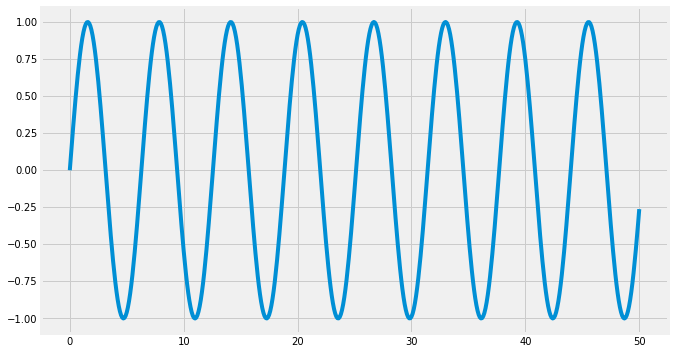

In [3]:
plt.figure(figsize=(10,6))
plt.plot(x,y)

In [4]:
data=pd.DataFrame(data=x,columns=['x'])
data['sine']=y

In [5]:
data.head()

,x,sine
0,0.0,0.000000
1,0.1,0.099833
2,0.2,0.198669
3,0.3,0.295520
4,0.4,0.389418


In [6]:
data.tail()

,x,sine
496,49.6,-0.617439
497,49.7,-0.535823
498,49.8,-0.448854
499,49.9,-0.357400
500,50.0,-0.262375


In [7]:
test_percent=0.1
ftest_number=np.round(len(data)*test_percent)
ftrain_number=int(len(data)-ftest_number)
ftrain_number

451

In [8]:
train_set=np.array(data.iloc[:ftrain_number,1]).reshape(-1,1)
test_Set=np.array(data.iloc[ftrain_number:,1]).reshape(-1,1)

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
scalar=MinMaxScaler()
scalar.fit(train_set)
scaled_train=scalar.transform(train_set)
scaled_test=scalar.transform(test_Set)

In [11]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [12]:
#help(TimeseriesGenerator)

In [13]:
length=2
batch_size=1
generator=TimeseriesGenerator(scaled_train,scaled_train,
                             length=length,batch_size=batch_size)

In [14]:
len(generator)

449

In [15]:
x,y=generator[0]
print(x)
print(y)

[[[0.49999912]
  [0.54991622]]]
[[0.59933458]]


In [16]:
length=50
batch_size=1
generator=TimeseriesGenerator(scaled_train,scaled_train,
                             length=length,batch_size=batch_size)

In [17]:
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM
from tensorflow.keras.models import Sequential

In [18]:
nf=1
model=Sequential()
model.add(SimpleRNN(50,input_shape=(length,nf)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 50)                2600      
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.fit_generator(generator,epochs=5)

Epoch 1/5
401/401 [==============================] - 15s 38ms/step - loss: 0.0067
Epoch 2/5
401/401 [==============================] - 15s 37ms/step - loss: 1.2496e-04
Epoch 3/5
401/401 [==============================] - 15s 37ms/step - loss: 2.6753e-04
Epoch 4/5
401/401 [==============================] - 15s 37ms/step - loss: 8.0592e-05
Epoch 5/5
401/401 [==============================] - 15s 37ms/step - loss: 1.3059e-04


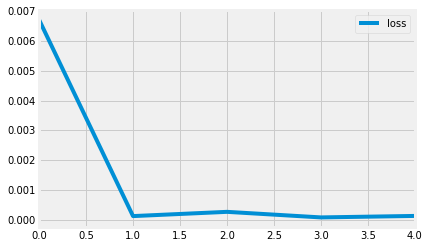

In [21]:
loss=pd.DataFrame(model.history.history)
loss.plot()

In [22]:
first_eval_batch=scaled_train[-length:]
first_eval_batch=first_eval_batch.reshape((1,length,nf))
print(np.squeeze(model.predict(first_eval_batch)))

0.9474757


In [23]:
scaled_test[0]

array([0.94955134])

In [24]:
predictions=[]
first_eval_batch=scaled_train[-length:]
current_batch=first_eval_batch.reshape((1,length,nf))

for i in range(len(scaled_test)):
    y_pred=model.predict(current_batch)[0]
    predictions.append(y_pred)
    current_batch=np.append(current_batch[:,1:,:],[[y_pred]],axis=1)

In [25]:
predictions

[array([0.9474757], dtype=float32),
 array([0.9660248], dtype=float32),
 array([0.97982824], dtype=float32),
 array([0.9879895], dtype=float32),
 array([0.991248], dtype=float32),
 array([0.9892743], dtype=float32),
 array([0.9824291], dtype=float32),
 array([0.97100264], dtype=float32),
 array([0.95483726], dtype=float32),
 array([0.9340738], dtype=float32),
 array([0.9088884], dtype=float32),
 array([0.87944055], dtype=float32),
 array([0.84602517], dtype=float32),
 array([0.8087068], dtype=float32),
 array([0.7682526], dtype=float32),
 array([0.72500074], dtype=float32),
 array([0.67898667], dtype=float32),
 array([0.63119805], dtype=float32),
 array([0.58218765], dtype=float32),
 array([0.5321805], dtype=float32),
 array([0.48215076], dtype=float32),
 array([0.43222266], dtype=float32),
 array([0.38270584], dtype=float32),
 array([0.33471256], dtype=float32),
 array([0.28826976], dtype=float32),
 array([0.24377875], dtype=float32),
 array([0.20194368], dtype=float32),
 array([0.162

In [26]:
prediction_set=scalar.inverse_transform(predictions)

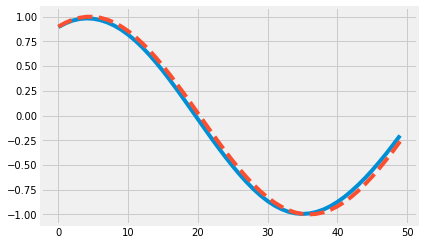

In [27]:
plt.plot(prediction_set)
plt.plot(test_Set,linestyle="dashed")

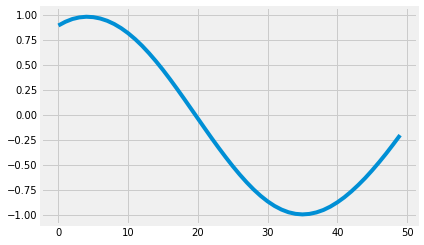

In [28]:
plt.plot(prediction_set)

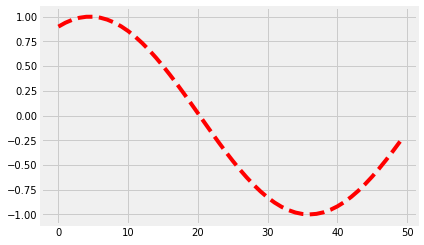

In [29]:
plt.plot(test_Set,linestyle="dashed",color="r")

In [30]:
final_comaprision=pd.DataFrame(test_Set,columns=["original"])
final_comaprision["prediction"]=prediction_set

In [31]:
final_comaprision.head()

,original,prediction
0,0.899097,0.894946
1,0.938307,0.932044
2,0.968142,0.959651
3,0.988304,0.975973
4,0.998591,0.982490


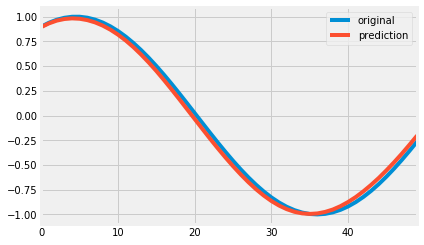

In [32]:
final_comaprision.plot()

In [44]:
from sklearn.metrics import explained_variance_score
explained_variance_score(final_comaprision["original"],final_comaprision["prediction"])*100

99.67553039101973

In [45]:
from tensorflow.keras.callbacks import EarlyStopping

In [52]:
earlystopping=EarlyStopping(monitor="val_loss",patience=3)

length=49
batch_size=1
generator=TimeseriesGenerator(scaled_train,scaled_train,
                             length=length,batch_size=batch_size)

validation_generator=TimeseriesGenerator(scaled_test,scaled_test,
                                        length=length,batch_size=batch_size)

In [53]:
nf=1
model=Sequential()
model.add(LSTM(50,input_shape=(length,nf)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [54]:
model.fit_generator(generator,epochs=20,
                   validation_data=validation_generator,
                   callbacks=[earlystopping])

Epoch 1/20
402/402 [==============================] - 27s 68ms/step - loss: 0.0134 - val_loss: 1.8964e-04
Epoch 2/20
402/402 [==============================] - 27s 67ms/step - loss: 1.4195e-04 - val_loss: 1.9446e-04
Epoch 3/20
402/402 [==============================] - 26s 66ms/step - loss: 1.3892e-04 - val_loss: 3.5631e-05
Epoch 4/20
402/402 [==============================] - 26s 65ms/step - loss: 3.1623e-04 - val_loss: 2.4504e-04
Epoch 5/20
402/402 [==============================] - 26s 65ms/step - loss: 7.1703e-05 - val_loss: 6.6884e-06 7.0257e - ETA: 2s - loss: 7.1 - ETA: 2 - ETA: 0s - l
Epoch 6/20
402/402 [==============================] - 27s 66ms/step - loss: 2.5955e-04 - val_loss: 4.1854e-05
Epoch 7/20
402/402 [==============================] - 26s 66ms/step - loss: 1.0565e-04 - val_loss: 6.1763e-08
Epoch 8/20
402/402 [==============================] - 26s 65ms/step - loss: 1.0537e-04 - val_loss: 9.0429e-06
Epoch 9/20
402/402 [==============================] - 26s 66ms/step - l

In [55]:
predictions=[]
first_eval_batch=scaled_train[-length:]
current_batch=first_eval_batch.reshape((1,length,nf))

for i in range(len(scaled_test)):
    y_pred=model.predict(current_batch)[0]
    predictions.append(y_pred)
    current_batch=np.append(current_batch[:,1:,:],[[y_pred]],axis=1)

In [56]:
predictions

[array([0.95955235], dtype=float32),
 array([0.9795059], dtype=float32),
 array([0.9950978], dtype=float32),
 array([1.0059593], dtype=float32),
 array([1.0118662], dtype=float32),
 array([1.0126989], dtype=float32),
 array([1.0084232], dtype=float32),
 array([0.9990801], dtype=float32),
 array([0.9847734], dtype=float32),
 array([0.9656618], dtype=float32),
 array([0.9419508], dtype=float32),
 array([0.91388524], dtype=float32),
 array([0.8817433], dtype=float32),
 array([0.84583414], dtype=float32),
 array([0.8064925], dtype=float32),
 array([0.76407915], dtype=float32),
 array([0.7189779], dtype=float32),
 array([0.6715984], dtype=float32),
 array([0.62237376], dtype=float32),
 array([0.5717614], dtype=float32),
 array([0.5202414], dtype=float32),
 array([0.46831438], dtype=float32),
 array([0.41649702], dtype=float32),
 array([0.36531737], dtype=float32),
 array([0.31530792], dtype=float32),
 array([0.26699916], dtype=float32),
 array([0.220911], dtype=float32),
 array([0.17754616]

In [57]:
prediction_set=scalar.inverse_transform(predictions)

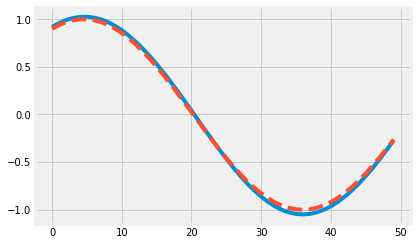

In [58]:
plt.plot(prediction_set)
plt.plot(test_Set,linestyle="dashed")

In [59]:
final_comaprision["lstmprediction"]=prediction_set

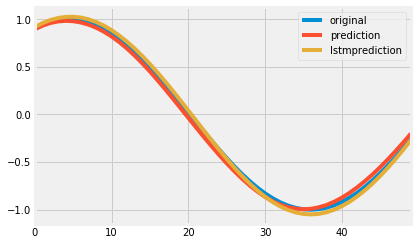

In [63]:
final_comaprision.plot()

In [64]:
explained_variance_score(final_comaprision["original"],final_comaprision["lstmprediction"])*100

99.8359750407962

In [76]:
fullscalar=MinMaxScaler()
full_scaled_data=fullscalar.fit_transform(np.array(data["sine"]).reshape(-1,1))

In [77]:
length=49
batch_size=1
generator=TimeseriesGenerator(full_scaled_data,full_scaled_data,
                             length=length,batch_size=batch_size)

In [78]:
nf=1
model=Sequential()
model.add(LSTM(50,input_shape=(length,nf)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [79]:
model.fit(generator,epochs=10)

Train for 452 steps
Epoch 1/10
452/452 [==============================] - 7s 16ms/step - loss: 0.0188
Epoch 2/10
452/452 [==============================] - 6s 14ms/step - loss: 1.5684e-04
Epoch 3/10
452/452 [==============================] - 6s 14ms/step - loss: 1.7867e-04
Epoch 4/10
452/452 [==============================] - 6s 14ms/step - loss: 2.1163e-04
Epoch 5/10
452/452 [==============================] - 6s 14ms/step - loss: 5.8594e-05
Epoch 6/10
452/452 [==============================] - 6s 14ms/step - loss: 2.1630e-04
Epoch 7/10
452/452 [==============================] - 6s 14ms/step - loss: 1.0956e-04
Epoch 8/10
452/452 [==============================] - 6s 14ms/step - loss: 6.5544e-05
Epoch 9/10
452/452 [==============================] - 6s 14ms/step - loss: 3.1459e-04
Epoch 10/10
452/452 [==============================] - 6s 14ms/step - loss: 1.8667e-04


In [103]:
predictions=[]
first_eval_batch=full_scaled_data[-length:]
current_batch=first_eval_batch.reshape((1,length,nf))
fl=500
for i in range(fl):
    y_pred=model.predict(current_batch)[0]
    predictions.append(y_pred)
    current_batch=np.append(current_batch[:,1:,:],[[y_pred]],axis=1)

In [124]:
prediction_set=fullscalar.inverse_transform(predictions)
temp=50.1+(fl*10)/100
forcast_index=np.arange(50.1,temp,step=0.1)
forcast_index=forcast_index.reshape(500,1)
len(forcast_index)
forcast_index.shape

(500, 1)

In [134]:
forcast_data=pd.DataFrame(data=forcast_index,columns=["x"])
forcast_data['sine']=prediction_set
forcast_data.head()

,x,sine
0,50.1,-0.164819
1,50.2,-0.062638
2,50.3,0.040994
3,50.4,0.145142
4,50.5,0.248846


In [137]:
frames=[data,forcast_data]
final_data=pd.concat(frames)
len(final_data)

1001

In [138]:
plt.plot(data["x"],data["sine"])
plt.plot(forcast_index,prediction_set)

In [144]:
plt.ion()
%matplotlib qt
bp=len(data["sine"])
fp=len(prediction_set)
tl=bp+fl
for i in range(tl):
    if i<bp:
        c="blue"
        xo=final_data["x"][0:i]
        yo=final_data["sine"][0:i]
        plt.plot(xo,yo,color=c)
    if i>=bp:
        c="red"
        xf=final_data["x"][bp:i]
        yf=final_data["sine"][bp:i]
        plt.plot(xo,yo,color="blue")
        plt.plot(xf,yf,color=c)
    plt.draw()
    plt.pause(0.005)
plt.show(block=True)
    